In [1]:
import pandas as pd
import mysql.connector
import os

# List of CSV files and their corresponding table names
csv_files = [
    ('customers.csv', 'customers'),
    ('orders.csv', 'orders'),
    ('sellers.csv', 'sellers'),
    ('products.csv', 'products'),
    ('geolocation.csv', 'geolocation'),
    ('payments.csv', 'payments'),
    ('order_items.csv','order_items')  
]

# Connect to the MySQL database
conn = mysql.connector.connect(
    host='localhost',
    user='root',
    port=3306,
    password='12345',
    database='target_sales'
)
cursor = conn.cursor()

# Folder containing the CSV files
folder_path = 'C:/Users/ATHARVA09VK18/Downloads/Target Sales'

def get_sql_type(dtype):
    if pd.api.types.is_integer_dtype(dtype):
        return 'INT'
    elif pd.api.types.is_float_dtype(dtype):
        return 'FLOAT'
    elif pd.api.types.is_bool_dtype(dtype):
        return 'BOOLEAN'
    elif pd.api.types.is_datetime64_any_dtype(dtype):
        return 'DATETIME'
    else:
        return 'TEXT'

for csv_file, table_name in csv_files:
    file_path = os.path.join(folder_path, csv_file)

    # Read the CSV file into a pandas DataFrame
    df = pd.read_csv(file_path)

    # Replace NaN with None to handle SQL NULL
    df = df.where(pd.notnull(df), None)

    # Debugging: Check for NaN values
    print(f"Processing {csv_file}")
    print(f"NaN values before replacement:\n{df.isnull().sum()}\n")

    # Clean column names
    df.columns = [col.replace(' ', '_').replace('-', '_').replace('.', '_') for col in df.columns]

    # Generate the CREATE TABLE statement with appropriate data types
    columns = ', '.join([f'`{col}` {get_sql_type(df[col].dtype)}' for col in df.columns])
    create_table_query = f'CREATE TABLE IF NOT EXISTS `{table_name}` ({columns})'
    cursor.execute(create_table_query)

    # Insert DataFrame data into the MySQL table
    for _, row in df.iterrows():
        # Convert row to tuple and handle NaN/None explicitly
        values = tuple(None if pd.isna(x) else x for x in row)
        sql = f"INSERT INTO `{table_name}` ({', '.join(['`' + col + '`' for col in df.columns])}) VALUES ({', '.join(['%s'] * len(row))})"
        cursor.execute(sql, values)

    # Commit the transaction for the current CSV file
    conn.commit()

conn.close()

Processing customers.csv
NaN values before replacement:
customer_id                 0
customer_unique_id          0
customer_zip_code_prefix    0
customer_city               0
customer_state              0
dtype: int64

Processing orders.csv
NaN values before replacement:
order_id                            0
customer_id                         0
order_status                        0
order_purchase_timestamp            0
order_approved_at                 160
order_delivered_carrier_date     1783
order_delivered_customer_date    2965
order_estimated_delivery_date       0
dtype: int64

Processing sellers.csv
NaN values before replacement:
seller_id                 0
seller_zip_code_prefix    0
seller_city               0
seller_state              0
dtype: int64

Processing products.csv
NaN values before replacement:
product_id                      0
product category              610
product_name_length           610
product_description_length    610
product_photos_qty            610
prod

In [34]:
import pandas as pd
import mysql.connector
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

db = mysql.connector.connect(
    host='localhost',
    user='root',
    port=3306,
    password='12345',
    database='target_sales'
)

cur = db.cursor()

# List all unique cities where customers are located.

In [3]:
query = """select distinct customer_city from customers limit 100"""
cur.execute(query)
data = cur.fetchall()
print(data)

[('franca',), ('sao bernardo do campo',), ('sao paulo',), ('mogi das cruzes',), ('campinas',), ('jaragua do sul',), ('timoteo',), ('curitiba',), ('belo horizonte',), ('montes claros',), ('rio de janeiro',), ('lencois paulista',), ('caxias do sul',), ('piracicaba',), ('guarulhos',), ('pacaja',), ('florianopolis',), ('aparecida de goiania',), ('santo andre',), ('goiania',), ('cachoeiro de itapemirim',), ('sao jose dos campos',), ('sao roque',), ('camacari',), ('resende',), ('sumare',), ('novo hamburgo',), ('sao luis',), ('sao jose',), ('santa barbara',), ('ribeirao preto',), ('ituiutaba',), ('taquarituba',), ('sao jose dos pinhais',), ('barrinha',), ('parati',), ('dourados',), ('trindade',), ('cascavel',), ('fortaleza',), ('brasilia',), ('pelotas',), ('porto alegre',), ('salto',), ('jundiai',), ('cacapava',), ('sao vicente',), ('uberlandia',), ('botelhos',), ('sao goncalo',), ('araucaria',), ('nova iguacu',), ('areia branca',), ('campos dos goytacazes',), ('sao carlos',), ('itajuba',), (

# Count the number of orders placed in 2017.

In [4]:
query = """select count(*) from orders where year(order_purchase_timestamp) = 2017"""
cur.execute(query)
data = cur.fetchall()
print('Total number of orders placed in 2017 are',data[0][0])

Total number of orders placed in 2017 are 45101


# Find the total sales per category.

In [5]:
query = """SELECT upper(p.product_category),round(sum(y.payment_value),2) as total FROM order_items o
inner join products p on o.product_id =p.product_id 
inner join payments y on o.order_id = y.order_id
group by product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Category","Sales"])
df

,Category,Sales
0,PERFUMERY,506738.66
1,FURNITURE DECORATION,1430176.39
2,TELEPHONY,486882.05
3,BED TABLE BATH,1712553.67
4,AUTOMOTIVE,852294.33
...,...,...
69,CDS MUSIC DVDS,1199.43
70,LA CUISINE,2913.53
71,FASHION CHILDREN'S CLOTHING,785.67
72,PC GAMER,2174.43


# Calculate the percentage of orders that were paid in more than 1 installment.

In [6]:
query = """select (select count(*) from payments where payment_installments > 1) * 100 / (select count(*) from payments) """
cur.execute(query)
data = cur.fetchall()
print('The percentage of orders that were paid in more than 1 installment',data[0][0])

The percentage of orders that were paid in more than 1 installment 49.4176


# Count the number of customers from each state. 

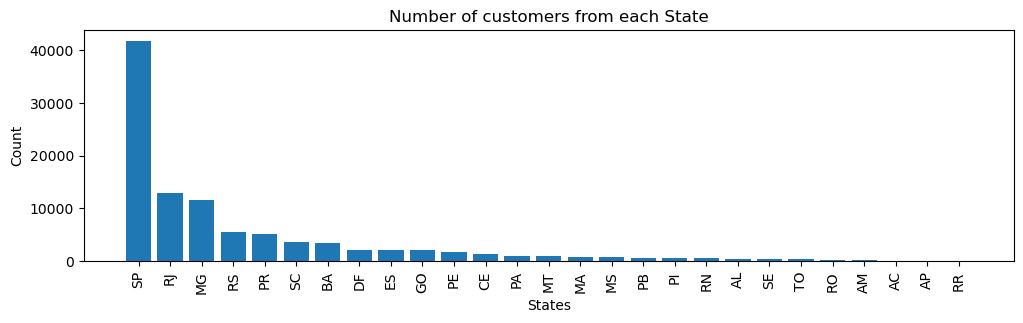

In [7]:
query = """select customer_state, count(customer_id) as customer_count from customers group by customer_state order by customer_count desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data,columns = ["State","Count"])
plt.figure(figsize= (12,3))
plt.bar(df["State"],df["Count"])
plt.xticks(rotation = 90)
plt.xlabel("States")
plt.ylabel("Count")
plt.title("Number of customers from each State")
plt.show()

# Calculate the number of orders per month in 2018.

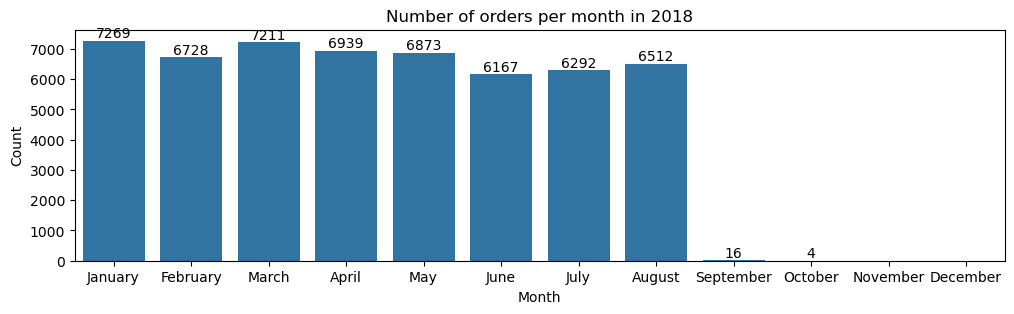

In [33]:
query = """select monthname(order_purchase_timestamp), count(*) from target_sales.orders where year(order_purchase_timestamp) = 2018 
group by monthname(order_purchase_timestamp)  """
cur.execute(query)
data = cur.fetchall()
data
df = pd.DataFrame(data,columns = ["Month","Count"])
o = ["January","February","March","April","May","June","July","August","September","October","November","December"]
plt.figure(figsize= (12,3))
ax=sns.barplot(x=df["Month"],y=df["Count"],data=df,order=o)
ax.bar_label(ax.containers[0])
plt.title("Number of orders per month in 2018")
plt.show()

# Find the average number of products per order, grouped by customer city.

In [36]:
query = """with count_per_order as (select o.order_id,o.customer_id,count(i.order_item_id) as count from orders o inner join order_items i 
on o.order_id = i.order_id group by o.order_id,o.customer_id)

select customers.customer_city,round(avg(count),2) as average_orders 
from customers inner join count_per_order on customers.customer_id = count_per_order.customer_id 
group by customers.customer_city order by average_orders desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer City","Average no. of products per order"])
df.head(20)

,Customer City,Average no. of products per order
0,padre carvalho,7.00
1,celso ramos,6.50
2,datas,6.00
3,candido godoi,6.00
4,matias olimpio,5.00
5,cidelandia,4.00
6,picarra,4.00
7,morro de sao paulo,4.00
8,teixeira soares,4.00
9,curralinho,4.00


# Calculate the percentage of total revenue contributed by each product category.

In [35]:
query = """SELECT upper(product_category) as Product_Category, round(sum(y.payment_value)/(select sum(payment_value) from payments) * 100,2) 
as percent_of_revenue FROM order_items o inner join products p on o.product_id =p.product_id 
inner join payments y on o.order_id = y.order_id 
group by product_category order by percent_of_revenue desc"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category","Percentage of total revenue"])
df.head(20)

,Product Category,Percentage of total revenue
0,BED TABLE BATH,10.70
1,HEALTH BEAUTY,10.35
2,COMPUTER ACCESSORIES,9.90
3,FURNITURE DECORATION,8.93
4,WATCHES PRESENT,8.93
5,SPORT LEISURE,8.70
6,HOUSEWARES,6.84
7,AUTOMOTIVE,5.32
8,GARDEN TOOLS,5.24
9,COOL STUFF,4.87


# Identify the correlation between product price and the number of times a product has been purchased.

In [38]:
query = """select p.product_category,count(o.product_id),round(avg(o.price),2) avg_price 
from order_items o inner join products p on o.product_id = p.product_id
group by product_category"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Product Category","Count","Average Price"])
arr1 = df["Count"]
arr2 = df["Average Price"]
a=np.corrcoef([arr1,arr2])
print('The correlation between product price and the number of times a product has been purchased is',round(a[0][1],4))

The correlation between product price and the number of times a product has been purchased is -0.1063


# Calculate the total revenue generated by each seller, and rank them by revenue.

In [4]:
query = """SELECT o.seller_id, ROUND(SUM(p.payment_value), 2) AS revenue,
    DENSE_RANK() OVER (ORDER BY SUM(p.payment_value) DESC) AS ranking
FROM order_items o INNER JOIN payments p ON o.order_id = p.order_id
GROUP BY o.seller_id ORDER BY ranking;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Seller_id","Revenue","Rank"])
df.head(20)

,Seller_id,Revenue,Rank
0,7c67e1448b00f6e969d365cea6b010ab,507166.91,1
1,1025f0e2d44d7041d6cf58b6550e0bfa,308222.04,2
2,4a3ca9315b744ce9f8e9374361493884,301245.27,3
3,1f50f920176fa81dab994f9023523100,290253.42,4
4,53243585a1d6dc2643021fd1853d8905,284903.08,5
5,da8622b14eb17ae2831f4ac5b9dab84a,272219.32,6
6,4869f7a5dfa277a7dca6462dcf3b52b2,264166.12,7
7,955fee9216a65b617aa5c0531780ce60,236322.30,8
8,fa1c13f2614d7b5c4749cbc52fecda94,206513.23,9
9,7e93a43ef30c4f03f38b393420bc753a,185134.21,10


# Calculate the moving average of order values for each customer over their order history.

In [18]:
query = """SELECT o.customer_id, o.order_purchase_timestamp, p.payment_value AS payment,
    ROUND(AVG(p.payment_value) OVER (PARTITION BY o.customer_id ORDER BY o.order_purchase_timestamp 
    ROWS BETWEEN 2 PRECEDING AND CURRENT ROW), 2) AS moving_avg
FROM orders o INNER JOIN payments p ON o.order_id = p.order_id
ORDER BY o.customer_id, o.order_purchase_timestamp;"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Customer ID","Order_purchase_timestamp","Payment","Moving_Avg"])
df

,Customer ID,Order_purchase_timestamp,Payment,Moving_Avg
0,00012a2ce6f8dcda20d059ce98491703,2017-11-14 16:08:26,114.74,114.74
1,000161a058600d5901f007fab4c27140,2017-07-16 09:40:32,67.41,67.41
2,0001fd6190edaaf884bcaf3d49edf079,2017-02-28 11:06:43,195.42,195.42
3,0002414f95344307404f0ace7a26f1d5,2017-08-16 13:09:20,179.35,179.35
4,000379cdec625522490c315e70c7a9fb,2018-04-02 13:42:17,107.01,107.01
...,...,...,...,...
103881,fffecc9f79fd8c764f843e9951b11341,2018-03-29 16:59:26,71.23,27.12
103882,fffeda5b6d849fbd39689bb92087f431,2018-05-22 13:36:02,63.13,63.13
103883,ffff42319e9b2d713724ae527742af25,2018-06-13 16:57:05,214.13,214.13
103884,ffffa3172527f765de70084a7e53aae8,2017-09-02 11:53:32,45.50,45.50


# Calculate the cumulative sales per month for each year.

In [13]:
query = """select year, month, payment, round(sum(payment) over(order by year,month),2) as cumulative_sales from
(select year(o.order_purchase_timestamp) year , month(o.order_purchase_timestamp) month, round(sum(p.payment_value),2) payment 
from orders o inner join payments p on o.order_id = p.order_id
group by year, month order by year,month) as a"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","Month","Payment","Cumulative Sales"])
df

,Year,Month,Payment,Cumulative Sales
0,2016,9,252.24,252.24
1,2016,10,59090.48,59342.72
2,2016,12,19.62,59362.34
3,2017,1,138488.04,197850.38
4,2017,2,291908.01,489758.39
5,2017,3,449863.60,939621.99
6,2017,4,417788.03,1357410.02
7,2017,5,592918.82,1950328.84
8,2017,6,511276.38,2461605.22
9,2017,7,592382.92,3053988.14


# Calculate the year-over-year growth rate of total sales.

In [10]:
query = """WITH revenue_per_year AS (SELECT year(o.order_purchase_timestamp) AS year,
        ROUND(SUM(p.payment_value), 2) AS total_revenue
    FROM orders o INNER JOIN payments p ON o.order_id = p.order_id
    GROUP BY year)
SELECT year,
    round(((total_revenue - LAG(total_revenue, 1, 0) OVER (ORDER BY year))/LAG(total_revenue, 1, 0) OVER (ORDER BY year) * 100),2) as "yoy % growth"
FROM revenue_per_year ORDER BY year"""

cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","YOY % Growth"])
df

,Year,YOY % Growth
0,2016,NaN
1,2017,12112.7
2,2018,20.0


# Identify the top 3 customers who spent the most money in each year.

In [9]:
query = """SELECT year, customer_id, payment, ranking
FROM (SELECT year(o.order_purchase_timestamp) AS year, o.customer_id, ROUND(SUM(p.payment_value), 2) AS payment,
        DENSE_RANK() OVER (PARTITION BY year(o.order_purchase_timestamp) ORDER BY SUM(p.payment_value) DESC) AS ranking
    FROM orders o INNER JOIN payments p ON o.order_id = p.order_id 
    GROUP BY year(o.order_purchase_timestamp), o.customer_id
) AS a
WHERE ranking <= 3"""
cur.execute(query)
data = cur.fetchall()
df = pd.DataFrame(data, columns = ["Year","Customer_id","Payment","Rank"])
df

,Year,Customer_id,Payment,Rank
0,2016,a9dc96b027d1252bbac0a9b72d837fc6,1423.55,1
1,2016,1d34ed25963d5aae4cf3d7f3a4cda173,1400.74,2
2,2016,4a06381959b6670756de02e07b83815f,1227.78,3
3,2017,1617b1357756262bfa56ab541c47bc16,13664.08,1
4,2017,c6e2731c5b391845f6800c97401a43a9,6929.31,2
5,2017,3fd6777bbce08a352fddd04e4a7cc8f6,6726.66,3
6,2018,ec5b2ba62e574342386871631fafd3fc,7274.88,1
7,2018,f48d464a0baaea338cb25f816991ab1f,6922.21,2
8,2018,e0a2412720e9ea4f26c1ac985f6a7358,4809.44,3
